In [1]:
import torch
import numpy as np
import random, os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
torch.cuda.set_device(0) 
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(torch.cuda.is_available())
def seed_it(seed):
    random.seed(seed)
    os.environ["PYTHONSEED"] = str(seed)
    np.random.seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
    torch.backends.cudnn.enabled = True
    torch.manual_seed(seed)
seed_it(42)

True


In [2]:
from models.LegalTrainer import *
trainer = LegalTrainer()
logger.info(trainer.__dict__)

In [3]:
# trainer.prepare_dataset()
trainer.prepare_civil_dataset_mini(path='dataset/C3RD_mini')

prepare_civil_dataset test: 100%|██████████| 2/2 [00:00<00:00, 249.78it/s]


In [ ]:
from models.trainer_utils import init_dual_model
model = init_dual_model(r'bert_ms')

In [7]:
def rank_emb_pre(dataset, bert_model):
    rank_emb = []
    for data in tqdm(dataset, desc='Encoding'):
        query = data['query']
        ctxs = data['ctxs']
        gt_idx = data['gt_idx']

        ctxs_accusation = [data['ctxs'][str(i)]['JudgeAccusation'] for i in range(100)]
        ctxs_reason = [data['ctxs'][str(i)]['JudgeReason'] for i in range(100)]
        ctxs_result = [data['ctxs'][str(i)]['JudgeResult'] for i in range(100)]

        q_emb = bert_model.encode([query], convert_to_tensor=True, show_progress_bar=False)
        c_emb_accusation = bert_model.encode(ctxs_accusation, convert_to_tensor=True, show_progress_bar=False)
        c_emb_reason = bert_model.encode(ctxs_reason, convert_to_tensor=True, show_progress_bar=False)
        c_emb_result = bert_model.encode(ctxs_result, convert_to_tensor=True, show_progress_bar=False)
        rank_emb.append([q_emb, c_emb_accusation, c_emb_reason, c_emb_result, gt_idx])
    return rank_emb

In [8]:
rank_emb_train = rank_emb_pre(trainer.dataset_train, model)
rank_emb_test = rank_emb_pre(trainer.dataset_test, model)

Encoding: 100%|██████████| 2/2 [00:06<00:00,  3.09s/it]


In [9]:
from dataloader.dataloader_utils import _get_rank_list, get_is_rel
from models.trainer_utils import get_score_oracle, get_score_fix_k, get_score_greedy_k
def input_prepare(dataset, rank_emb):
    rank_lists_avg = []
    for i in trange(len(rank_emb), desc='input_prepare'):
        q_emb, c_emb_accusation, c_emb_reason, c_emb_result, gt_idx = rank_emb[i]
        c_emb_avg = (c_emb_accusation + c_emb_reason + c_emb_result) / 3
        rank_list_avg, rank_score_avg = _get_rank_list(q_emb, c_emb_avg)
        rank_lists_avg.append(rank_list_avg)

    label_lists = []
    for i in trange(len(dataset), desc='input_prepare'):
        ctxs = dataset[i]['ctxs']
        gt_label = [1 if j in dataset[i]['gt_idx'] else 0 for j in range(100)]
        is_rel = get_is_rel(gt_label, rank_lists_avg[i])
        label_lists.append(is_rel)
    return label_lists

def get_stat_score(dataset_train, dataset_test, rank_emb_train, rank_emb_test):
    label_lists_train = input_prepare(dataset_train, rank_emb_train)
    label_lists_test = input_prepare(dataset_test, rank_emb_test)
    print(f'Oracle train: {get_score_oracle(label_lists_train)}, test {get_score_oracle(label_lists_test)}')
    ks = [5, 10, 20, 30, 50]
    for k in ks:
        print(f'Fix@{k} train: {get_score_fix_k(label_lists_train, k)}, test: {get_score_fix_k(label_lists_test, k)}')
    print(f'Greedy: {get_score_greedy_k(label_lists_train, label_lists_test)}')

In [10]:
get_stat_score(trainer.dataset_train, trainer.dataset_test, rank_emb_train, rank_emb_test)

input_prepare: 100%|██████████| 2/2 [00:00<?, ?it/s]


Oracle train: (0.4509093924651201, 1.464470831624471, 0.13233477569557728), test (0.5420906567992599, 2.230905342297669, 0.15934959352296718)
Fix@5 train: (0.2710672905525847, -0.3402029043004223, 0.08228303193030806), test: (0.3125, 0.0, 0.09489200719555146)
Fix@10 train: (0.35761122935035977, -0.8975687913519891, 0.11190572468059419), test: (0.4285714285714286, -0.31546487678572865, 0.13231303058528474)
Fix@20 train: (0.3083915313534879, -2.758134376561221, 0.11604387933351826), test: (0.3548387096774194, -2.262992820542445, 0.13617242834647836)
Fix@30 train: (0.2743873193115035, -4.503620330724171, 0.1145114583734782), test: (0.2977044476327116, -4.163240751002315, 0.13607625405916607)
Fix@50 train: (0.21015036641831364, -7.966391669656177, 0.0998443840029345), test: (0.23588342440801457, -7.516223160115247, 0.12462498444622627)
Greedy: (0.45454545454545453, 0.0, 0.1397683223262538)


In [13]:
from dataloader.milecut_dataloader import dataloader as mile_dataloader
train_loader, test_loader, _ = mile_dataloader(trainer.dataset_train, trainer.dataset_test, rank_emb_train, rank_emb_test, batch_size=1, input_size=6)
trainer.train_loader, trainer.test_loader = train_loader, test_loader

prepare dataset_train


input_prepare: 100%|██████████| 8/8 [00:00<00:00, 532.84it/s]


prepare dataset_test
oracle train: (0.4509093924651201, 1.464470831624471, 0.13233477569557728)


input_prepare: 100%|██████████| 2/2 [00:00<00:00, 399.61it/s]

oracle test: (0.5420906567992599, 2.230905342297669, 0.15934959352296718)


INFO:logs/trainer_20240414-21-29.log:epoch: 30, lr:3e-05, reset_params: True, dropout:0.2, weight_decay:0.005, model_name: MileCut, loss function: MileCut, loss coefficient: 0.6, input_size: 6, batch_size: 20, set_train_seed=True, train_seed=42, view_input_size=3, label_input_size: 9
Training for epoch_0: 100%|██████████| 8/8 [00:00<00:00, 11.20it/s]
INFO:logs/trainer_20240414-21-29.log:epoch: 0, Train: loss = 3.34944349527359 | f1 = 0.173281 | dcg = -11.849764 | oie = 0.076634
Test after epoch_0: 100%|██████████| 2/2 [00:00<00:00, 19.29it/s]
INFO:logs/trainer_20240414-21-29.log:epoch: 0, Test: loss = 3.2171730995178223 | f1 = 0.156201 | dcg = -13.421079 | oie = 0.108511
INFO:logs/trainer_20240414-21-29.log:epoch: 0 | best_test_f1 = 0.156201 | dcg = -13.421079 | oie = 0.108511
INFO:logs/trainer_20240414-21-29.log:The best model has beed updated and saved in models/output/MileCut20240414-21-33.pkl

Test after epoch_1: 100%|██████████| 2/2 [00:00<00:00, 18.85it/s]
INFO:logs/trainer_20240

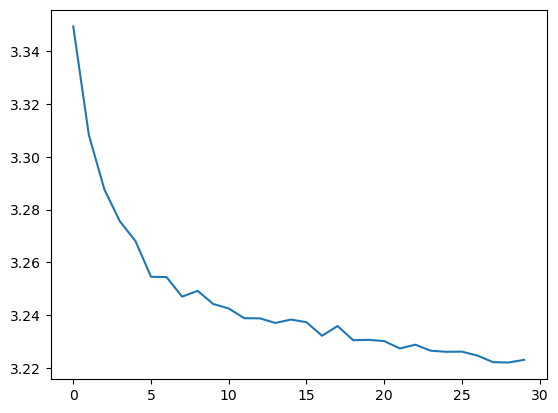

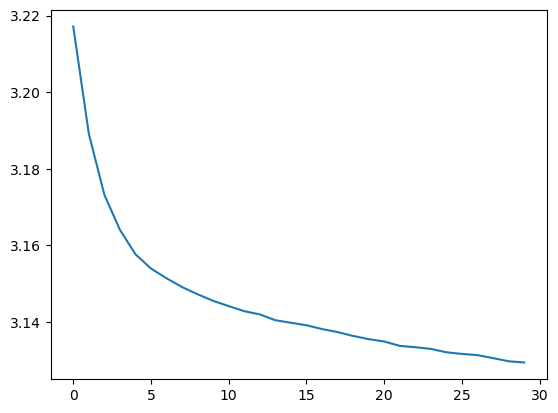

In [15]:
trainer.run(reset_params=True, loss_name='MileCut', model_name='MileCut', epoch=30, coefficient=0.6, input_size=6, set_train_seed=True, train_seed=42,view_input_size=3, label_input_size=9)